## Laboratorium 4 - algorytm Najbliższej Średniej (NM)


### Opis
Celem laboratorium jest implementacja klasyfikatora najbliższej średniej NM (*Nearest Mean*).


### Zadanie

Należy wykonać następujące czynności w celu realizacji niniejszego zadania:
* Wczytaj dane.
* **Zaimplementuj klasyfikator najbliższej średniej (NM) z zastosowaniem odległości Euklidesa**.
* Zaimplementuj funkcję, która zwraca macierz kowariancji (*uwaga: biblioteka `numpy` posiada gotową implementację `cov` z którą możesz porównać wynik*).

    \begin{equation*}
    C = \frac{1}{n - 1} (X - \bar X)(X - \bar X)^T
    \end{equation*}

    gdzie:
    * $X$ to macierz, 
    * $\bar X$ to wektor ze średnimi wartościami cech. 

* **Zaimplementuj klasyfikator najbliższej średniej (NM) z zastosowaniem odległości Machalanobisa**.

    \begin{equation*}
    D_j = \sqrt{ (x - \mu_j)^T S_j^{-1}(x - \mu_j) },
    \end{equation*}

    gdzie:
    * $D_j$ to odległość klasyfikowanej próbki do $j$-tej klasy (grupy, klastra), 
    * $\mu_j$ to wektor ze średnimi wartościami cech w obrębie $j$-tej klasy, 
    * $S_j^{-1}$ to odwrócona macierz kowariancji $j$-tej klasy, 
    * a $x$ to klasyfikowana próbka.

* Opisz wyniki klasyfikatorów i porównaj je z klasyfikatorem *k*NN (porównaj w kontekście różnych metryk - obowiązkowo tablica pomyłek).

> Podpowiedź 1: Do obliczenia macierzy odwrotnej możesz użyć gotową implementację, np. funkcję `linalg.inv` z biblioteki `numpy`.

> Podpowiedź 2: Do wszelkich podstawowych operacji na macierzach (mnożenie, transpozycja, dodawanie, odejmowanie, itp.) możesz zastosować gotową implementację, np. bibliotekę `numpy`.

> UWAGA 1: W niniejszym zadaniu jest dowolność implementacji (nie trzeba trzymać się struktury z poprzedniego zadania), jednak algorytm NM należy zaimplementować samodzielnie bez korzystania z istniających rozwiązań (jak np. z biblioteki `scikit-learn`).

> UWAGA 2: Wszystkie wykonane elementy zadania powinny posiadać stosowne komentarze i opisy.


**Pamiętaj, wyniki powinny być czytelnie opisane oraz zaprezentowane graficznie (jeżeli jest taka możliwość).**

Przykład (na podstawie tablicy pomyłek):

**Źle** (nie wiadomo co jest poniżej zaprezentowane, kolumny ani wiersze nie są podpisane, nie wiadomo które z nich prezentują predykcje, a które właściwe etykiety):
```
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
```


<span style="text-decoration:underline">Referencje</span>

1. Mahalanobis, P C, _On test and measures of group divergence : theoretical formulae_, Journal and Proceedings of Asiatic Society of Bengal (New Series) Vol. 26, pp. 541-588. 1930. (URL: http://library.isical.ac.in:8080/xmlui/bitstream/handle/10263/1639/029.pdf)
2. McLachlan, Goeffrey J. _Mahalanobis distance_, Resonance, pp. 20-26. 1999. (URL: https://www.ias.ac.in/article/fulltext/reso/004/06/0020-0026)

In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Wczytywanie danych

In [2]:
# Wczytywanie danych
with open('./dataset/dataset.npz', 'rb') as f:
    data = np.load(f)
    train, test = data['train'], data['test']

    train_y, train_x = np.hsplit(train, [1])
    test_y, test_x = np.hsplit(test, [1])
    
    train_y = train_y.flatten()
    test_y = test_y.flatten()

In [3]:
# Funkcja do filtrowania wybranych klas ze zbioru danych
def filter_classes(classes):
    train_indexes = np.zeros((train.shape[0],), dtype=np.bool_)
    test_indexes = np.zeros((test.shape[0],), dtype=np.bool_)
    for class_ in classes:
        train_indexes |= train[:, 0] == class_
        test_indexes |= test[:, 0] == class_
    return train[train_indexes, 1:], test[test_indexes, 1:], train[train_indexes, 0], test[test_indexes, 0]

## Implementacja klasyfikatora NM (odległość Euklidesa)

In [5]:
class NMEuclideanClassifier:
    
    def __init__(self, features=None):
        self._means = None
        self._classes = None
        self._features = features
    
    def fit(self, X, y):
        self._classes = np.unique(y)
        self._means = np.array([self._get_mean(X, y, class_) for class_ in self._classes])
        
    def _get_mean(self, X, y, class_):
        selected = y == class_
        X_selected = X[selected]
        mean = np.mean(X_selected, axis=0)
        return mean
        
    def predict(self, X):
        classes = np.array([self._predict_single(x) for x in X])
        return classes
        
    def _predict_single(self, x):
        distances = np.array([self._distance_to_class(x, class_) for class_ in self._classes])
        best_distance_index = np.argmin(distances)
        return self._classes[best_distance_index]
        
    def _distance_to_class(self, x, class_):
        index = np.where(self._classes == class_)
        mean = self._means[index].flatten()
        return self._euclidean_distance(x, mean)
        
    def _euclidean_distance(self, x1, x2):
        if self._features is not None:
            x1 = x1[self._features]
            x2 = x2[self._features]
        return math.dist(x1, x2)

Accuracy: 0.61
Balanced Accuracy: 0.70
Matthews Correlation: 0.33


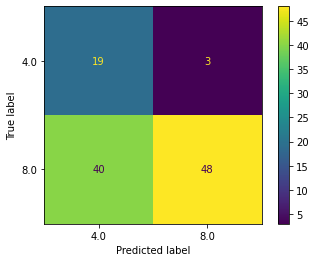

In [6]:
# Szybki test
perform_test(NMEuclideanClassifier, classes=[4, 8], features=[7, 4, 8, 9])

## Obliczanie kowariancji 

In [5]:
def cov(X):
    Xm = np.mean(X, axis=0)
    diff = X - Xm
    return 1 / (X.shape[0]-1) * (diff.T @ diff)

In [6]:
# Test funkcji cov
matrix = np.random.randn(1000, 10)
my_cov = cov(matrix)
np_cov = np.cov(matrix.T)
assert np.all(my_cov == np_cov)

## Implementacja klasyfikatora NM (odległość Mahalanobisa)

In [41]:
from numpy import linalg

class NMMahalanobisClassifier:
    
    def __init__(self, features=None):
        self._means = None
        self._covar = None
        self._classes = None
        self._features = features
    
    def fit(self, X, y):
        self._classes = np.unique(y)
        self._means = np.array([self._get_mean(X, y, class_) for class_ in self._classes])
        self._covar = np.array([self._get_covariation(X, y, class_) for class_ in self._classes])
        
    def _get_mean(self, X, y, class_):
        selected = y == class_
        X_selected = X[selected]
        mean = np.mean(X_selected, axis=0)
        return mean
    
    def _get_covariation(self, X, y, class_):
        selected = y == class_
        X_selected = X[selected]
        covariation = cov(X_selected)
        return covariation
        
    def predict(self, X):
        classes = np.array([self._predict_single(x) for x in X])
        return classes
        
    def _predict_single(self, x):
        distances = np.array([self._distance_to_class(x, class_) for class_ in self._classes])
        best_distance_index = np.argmin(distances)
        return self._classes[best_distance_index]
        
    def _distance_to_class(self, x, class_):
        index = np.where(self._classes == class_)
        mean = self._means[index].flatten()
        covar = self._covar[index]
        diff = x - mean
        return diff.T@linalg.inv(covar)@diff

Accuracy: 1.00
Balanced Accuracy: 1.00
Matthews Correlation: 1.00


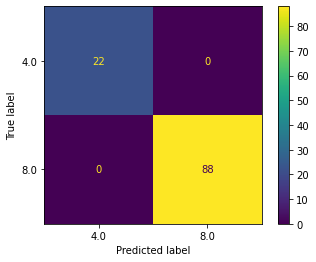

In [42]:
# Szybki test
perform_test(NMMahalanobisClassifier, classes=[4, 8], features=[7, 4, 8, 9])

## Testy dla różnej liczby klas

In [64]:
# Funckcja uruchamiająca klasyfikator dla zadanego k, liczby klas i wybranych cech
from sklearn.metrics import accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay, matthews_corrcoef

def perform_test(classifier, classes, features, ax=None):
    train_x, test_x, train_y, test_y = filter_classes(classes)
    classifier = classifier(features=features)
    classifier.fit(train_x, train_y)
    predictions = classifier.predict(test_x)
    
    accuracy = accuracy_score(test_y, predictions)
    balanced_accuracy = balanced_accuracy_score(test_y, predictions)
    matthews = matthews_corrcoef(test_y, predictions)
    
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Balanced Accuracy: {balanced_accuracy:.2f}')
    print(f'Matthews Correlation: {matthews:.2f}')
    
    ConfusionMatrixDisplay.from_predictions(test_y, predictions, ax=ax)
    
def perform_comparison(classes, features):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    print('Odległość Euklidesa:')
    perform_test(NMEuclideanClassifier, classes, features, axs[0])
    print('\nOdległość Mahalanobisa:')
    perform_test(NMMahalanobisClassifier, classes, features, axs[1])
    axs[0].set_title('Odległość Euklidesa')
    axs[1].set_title('Odległość Mahalanobisa')

### 2 klasy

Wyniki KNN:

    Accuracy: 1.00
    Balanced Accuracy: 1.00
    Matthews Correlation: 1.00

Odległość Euklidesa:
Accuracy: 1.00
Balanced Accuracy: 1.00
Matthews Correlation: 1.00

Odległość Mahalanobisa:
Accuracy: 0.96
Balanced Accuracy: 0.96
Matthews Correlation: 0.93


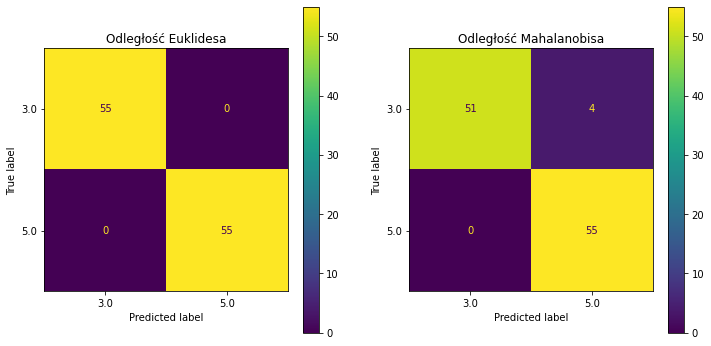

In [75]:
perform_comparison(classes=[3, 5], features=[3, 7])

### 4 klasy

Wyniki KNN:

    Accuracy: 0.86
    Balanced Accuracy: 0.86
    Matthews Correlation: 0.82

Odległość Euklidesa:
Accuracy: 0.72
Balanced Accuracy: 0.72
Matthews Correlation: 0.63

Odległość Mahalanobisa:
Accuracy: 0.88
Balanced Accuracy: 0.88
Matthews Correlation: 0.85


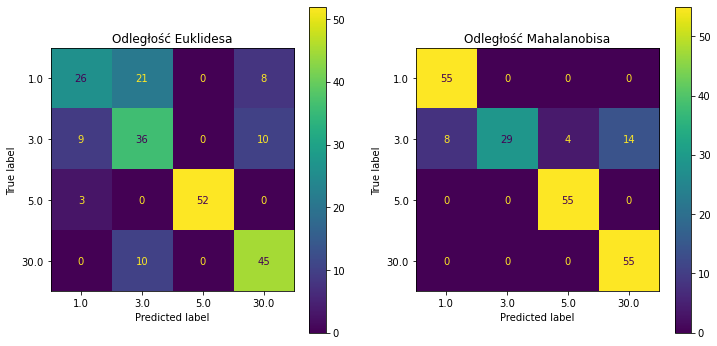

In [76]:
perform_comparison(classes=[1, 3, 5, 30], features=[3, 7])

### 15 klas (wszystkie)

Wyniki KNN:

    Accuracy: 0.55
    Balanced Accuracy: 0.51
    Matthews Correlation: 0.51

Odległość Euklidesa:
Accuracy: 0.42
Balanced Accuracy: 0.39
Matthews Correlation: 0.38

Odległość Mahalanobisa:
Accuracy: 0.71
Balanced Accuracy: 0.71
Matthews Correlation: 0.70


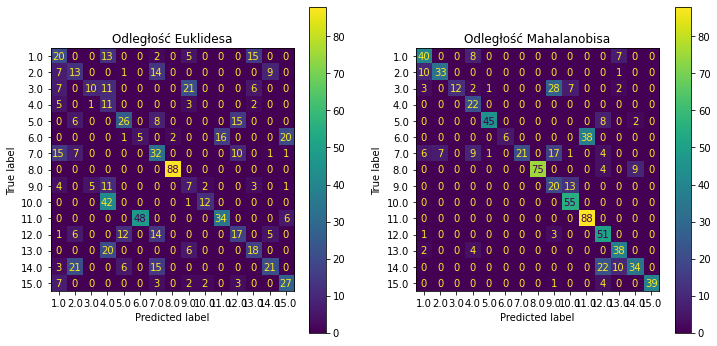

In [77]:
perform_comparison(classes=list(range(1, 16)), features=[3, 7])

## Testy dla różnej liczby cech

### 2 cechy

Wyniki KNN:

    Accuracy: 0.86
    Balanced Accuracy: 0.86
    Matthews Correlation: 0.82

Odległość Euklidesa:
Accuracy: 0.72
Balanced Accuracy: 0.72
Matthews Correlation: 0.63

Odległość Mahalanobisa:
Accuracy: 0.88
Balanced Accuracy: 0.88
Matthews Correlation: 0.85


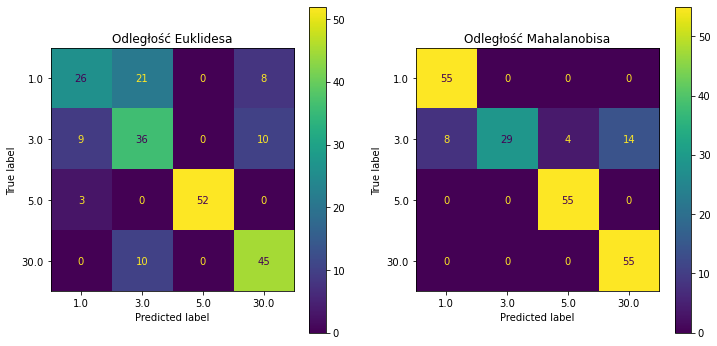

In [78]:
perform_comparison(classes=[1, 3, 5, 30], features=[3, 7])

### 5 cech

Wyniki KNN:

    Accuracy: 0.92
    Balanced Accuracy: 0.92
    Matthews Correlation: 0.89

Odległość Euklidesa:
Accuracy: 0.84
Balanced Accuracy: 0.84
Matthews Correlation: 0.78

Odległość Mahalanobisa:
Accuracy: 0.88
Balanced Accuracy: 0.88
Matthews Correlation: 0.85


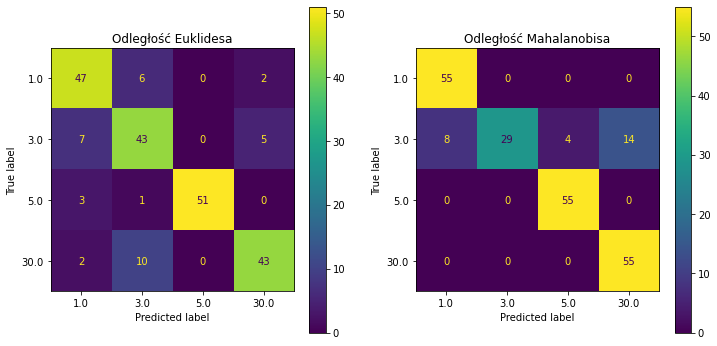

In [79]:
perform_comparison(classes=[1, 3, 5, 30], features=[1, 2, 3, 7, 8])

### 15 cech (wszystkie)

Wyniki KNN:

    Accuracy: 0.21
    Balanced Accuracy: 0.21
    Matthews Correlation: -0.06

Odległość Euklidesa:
Accuracy: 0.50
Balanced Accuracy: 0.50
Matthews Correlation: 0.36

Odległość Mahalanobisa:
Accuracy: 0.88
Balanced Accuracy: 0.88
Matthews Correlation: 0.85


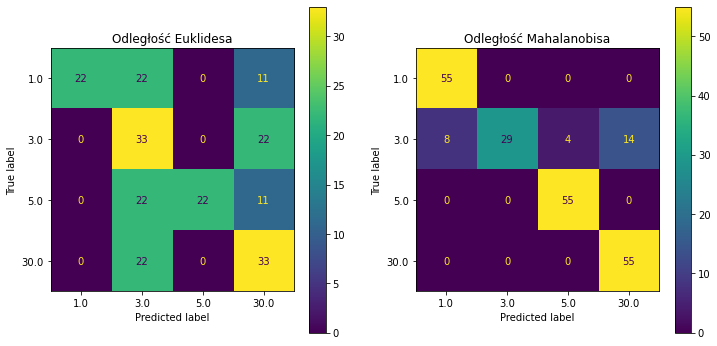

In [81]:
perform_comparison(classes=[1, 3, 5, 30], features=list(range(15)))

## Wnioski

Klasyfikator wykorzystujący odległość Mahalanobisa daje znacznie lepsze wyniki niż też używający odległość Euklidesa, ponieważ niweluje on złe skutki nieprzeskalowanych danych.

W większości przypadków klasyfikator NM z odległością Mahalanobisa  działał lepiej od klasyfikatora KNN. Dodatkowo dużą jego zaletą, jest znacznie mniejsze zużycie pamięci oraz mniejsza złożoność obliczeniowa.